Target: Add batch normalization to increase efficiency <br>

Results: <br>
Parameters: 8,680 (<10K) <br> <br>
Best Training Accuracy: 99.75 <br>
Best Test Accuracy: 99.15 <br>

Analysis: <br>
Good model, train, test accuracy increased over previous experiment <br>

In [1]:
!pip install torchsummary

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -28 Output- 26 RF 3
        self.b1c1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 1, padding=0)
        self.b2c2 = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 20, 1, padding=0)
        self.b3c3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1)
        self.b4c4 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.AdaptiveAvgPool2d(7)
        self.conv5 = nn.Conv2d(20, 10, 3)
        self.b5c5 = nn.BatchNorm2d(10)
        self.conv6 = nn.Conv2d(10, 10, 5)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = (F.relu(self.b2c2(self.conv2(F.relu(self.b1c1(self.conv1(x)))))))
        x = nn.Dropout(0.25)(x) 
        x = self.pool1(x)       
        x = (F.relu(self.b4c4(self.conv4(F.relu(self.b3c3(self.conv3(x)))))))
        x = self.pool2(x)
        #x = nn.Dropout(0.25)(x)        
        x = F.relu(self.conv6(F.relu(self.b5c5(self.conv5(x)))))
        #x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [15]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
            Conv2d-3           [-1, 20, 28, 28]             220
       BatchNorm2d-4           [-1, 20, 28, 28]              40
         MaxPool2d-5           [-1, 20, 14, 14]               0
            Conv2d-6           [-1, 20, 14, 14]             420
       BatchNorm2d-7           [-1, 20, 14, 14]              40
            Conv2d-8           [-1, 20, 14, 14]           3,620
       BatchNorm2d-9           [-1, 20, 14, 14]              40
        MaxPool2d-10             [-1, 20, 7, 7]               0
           Conv2d-11             [-1, 10, 5, 5]           1,810
      BatchNorm2d-12             [-1, 10, 5, 5]              20
           Conv2d-13             [-1, 10, 1, 1]           2,510
Total params: 8,840
Trainable params: 8

In [16]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy.append(100*correct/len(train_loader.dataset))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

             
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100*correct/len(test_loader.dataset)) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nEpoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch:  1


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.04521368816494942 batch_id=468 Accuracy = 86.14: 100%|████████████████████████| 469/469 [00:18<00:00, 26.01it/s]



Train set: Average loss: 0.4325, Accuracy: 51681/60000 (86.14%)

Test set: Average loss: 0.0738, Accuracy: 9770/10000 (97.70%)


Epoch:  2


loss=0.032749004662036896 batch_id=468 Accuracy = 98.03: 100%|███████████████████████| 469/469 [00:17<00:00, 27.46it/s]



Train set: Average loss: 0.0656, Accuracy: 58818/60000 (98.03%)

Test set: Average loss: 0.0500, Accuracy: 9854/10000 (98.54%)


Epoch:  3


loss=0.023279016837477684 batch_id=468 Accuracy = 98.55: 100%|███████████████████████| 469/469 [00:16<00:00, 27.90it/s]



Train set: Average loss: 0.0494, Accuracy: 59127/60000 (98.55%)

Test set: Average loss: 0.0376, Accuracy: 9886/10000 (98.86%)


Epoch:  4


loss=0.019877443090081215 batch_id=468 Accuracy = 98.69: 100%|███████████████████████| 469/469 [00:17<00:00, 26.71it/s]



Train set: Average loss: 0.0414, Accuracy: 59215/60000 (98.69%)

Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)


Epoch:  5


loss=0.06875503808259964 batch_id=468 Accuracy = 98.87: 100%|████████████████████████| 469/469 [00:16<00:00, 28.37it/s]



Train set: Average loss: 0.0363, Accuracy: 59324/60000 (98.87%)

Test set: Average loss: 0.0315, Accuracy: 9901/10000 (99.01%)


Epoch:  6


loss=0.032682955265045166 batch_id=468 Accuracy = 98.98: 100%|███████████████████████| 469/469 [00:17<00:00, 27.09it/s]



Train set: Average loss: 0.0322, Accuracy: 59387/60000 (98.98%)

Test set: Average loss: 0.0324, Accuracy: 9894/10000 (98.94%)


Epoch:  7


loss=0.03234188258647919 batch_id=468 Accuracy = 99.07: 100%|████████████████████████| 469/469 [00:15<00:00, 30.07it/s]



Train set: Average loss: 0.0300, Accuracy: 59442/60000 (99.07%)

Test set: Average loss: 0.0383, Accuracy: 9882/10000 (98.82%)


Epoch:  8


loss=0.055612076073884964 batch_id=468 Accuracy = 99.12: 100%|███████████████████████| 469/469 [00:17<00:00, 26.94it/s]



Train set: Average loss: 0.0276, Accuracy: 59471/60000 (99.12%)

Test set: Average loss: 0.0295, Accuracy: 9903/10000 (99.03%)


Epoch:  9


loss=0.008439312689006329 batch_id=468 Accuracy = 99.21: 100%|███████████████████████| 469/469 [00:16<00:00, 29.26it/s]



Train set: Average loss: 0.0246, Accuracy: 59525/60000 (99.21%)

Test set: Average loss: 0.0316, Accuracy: 9905/10000 (99.05%)


Epoch:  10


loss=0.021251747384667397 batch_id=468 Accuracy = 99.33: 100%|███████████████████████| 469/469 [00:15<00:00, 30.32it/s]



Train set: Average loss: 0.0224, Accuracy: 59596/60000 (99.33%)

Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)


Epoch:  11


loss=0.04655633494257927 batch_id=468 Accuracy = 99.33: 100%|████████████████████████| 469/469 [00:15<00:00, 31.11it/s]



Train set: Average loss: 0.0219, Accuracy: 59596/60000 (99.33%)

Test set: Average loss: 0.0328, Accuracy: 9887/10000 (98.87%)


Epoch:  12


loss=0.02240697480738163 batch_id=468 Accuracy = 99.35: 100%|████████████████████████| 469/469 [00:17<00:00, 26.09it/s]



Train set: Average loss: 0.0201, Accuracy: 59610/60000 (99.35%)

Test set: Average loss: 0.0320, Accuracy: 9898/10000 (98.98%)


Epoch:  13


loss=0.021684417501091957 batch_id=468 Accuracy = 99.41: 100%|███████████████████████| 469/469 [00:16<00:00, 28.12it/s]



Train set: Average loss: 0.0186, Accuracy: 59646/60000 (99.41%)

Test set: Average loss: 0.0305, Accuracy: 9895/10000 (98.95%)


Epoch:  14


loss=0.03761805593967438 batch_id=468 Accuracy = 99.45: 100%|████████████████████████| 469/469 [00:17<00:00, 26.99it/s]



Train set: Average loss: 0.0177, Accuracy: 59671/60000 (99.45%)

Test set: Average loss: 0.0291, Accuracy: 9899/10000 (98.99%)


Epoch:  15


loss=0.012834002263844013 batch_id=468 Accuracy = 99.44: 100%|███████████████████████| 469/469 [00:17<00:00, 26.54it/s]



Train set: Average loss: 0.0169, Accuracy: 59661/60000 (99.44%)

Test set: Average loss: 0.0307, Accuracy: 9901/10000 (99.01%)



Text(0.5, 1.0, 'Test_Accuracy')

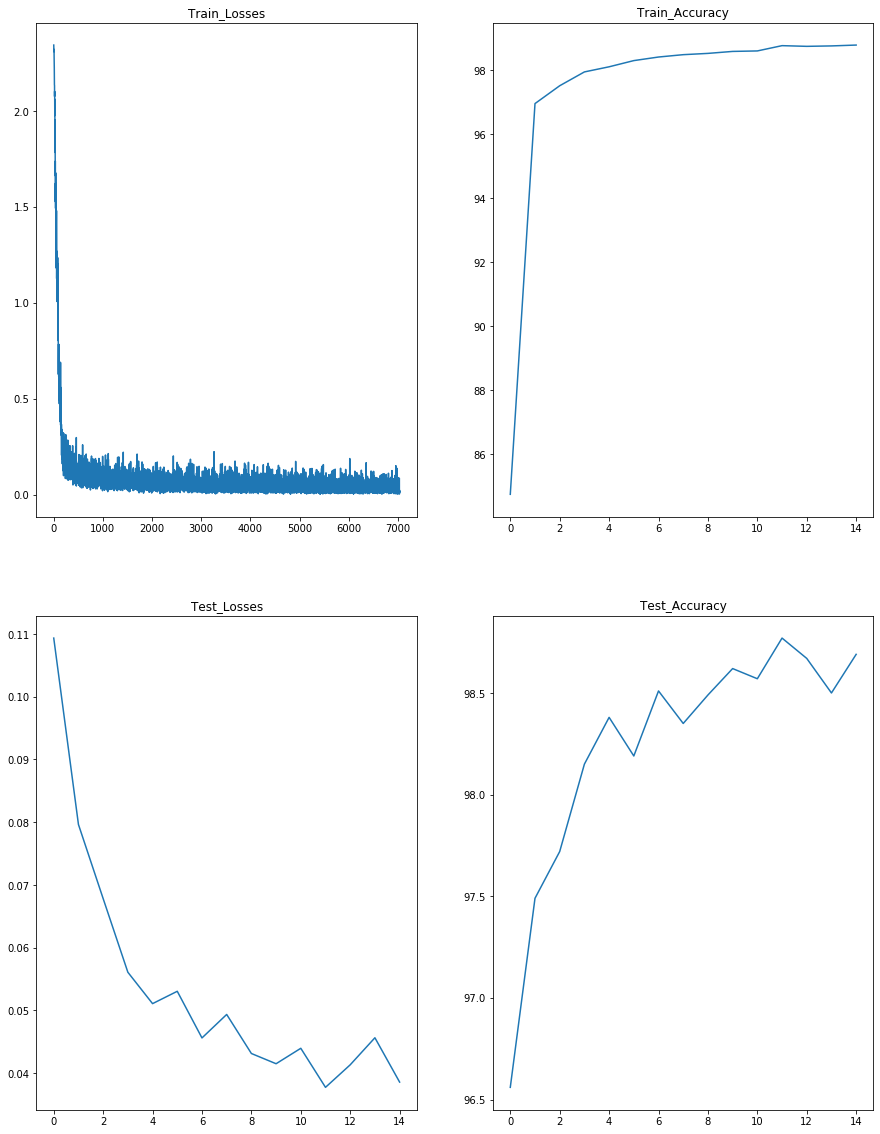

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(15,20))
ax[0,0].plot(train_losses)
ax[0,0].set_title('Train_Losses')
ax[0,1].plot(train_accuracy)
ax[0,1].set_title('Train_Accuracy')

ax[1,0].plot(test_losses)
ax[1,0].set_title('Test_Losses')
ax[1,1].plot(test_accuracy)
ax[1,1].set_title('Test_Accuracy')